## Random Forest Classifier

### Description

This script will classify the major classes of the intertidal zone (e.g. mangroves, clay-pans and salt marshes) using the annual geomedians and summary statistics produced by the script `TidallyFilteredComposites.ipynb` and a Random Forest Classifier. The workflow is as follows:

1. Import training data
2. Fit a model
3. Classify an image
4. Assess feature importance
5. Assess RF parameters
6. Export tree diagrams

### Technical details

* Analyses used: `Random Forest Classfication`

### Getting Started
There are a number of very important things to consider when attempting to use a Random Forest Classifier.  Consider the following before running this analysis (most of this info has been gleaned from the following review article [here](https://www.tandfonline.com/doi/full/10.1080/01431161.2018.1433343).  Some more general information about the Random Forest algorithm is available [here](https://www.kdnuggets.com/2017/10/random-forests-explained.html)
 
 - **Training data:**
     - The most important part of any machine learning workflow. The quality of the training data has a greater impact of the classification than the algorithm used. Large and accurate training data sets are preferable: increasing the training sample size results in increased classification accuracy (Huang, Davis and Townsend 2002).
     
     - When creating training data, be sure to capture the spectral variability of the class. The best way to create training data is using a GIS platform. If you have access to ArcGIS Pro, there is a new tool that facilitates the easy capture of training data, and includes useful features like adjusting for class imbalance (see below). The tool collection is [here](https://pro.arcgis.com/en/pro-app/help/analysis/image-analyst/training-samples-manager.htm).
     
     - Random Forest (RF) classifiers are moderately robust to miss-classifications in the training data, as long as the errors are < 10-20 %
     
     - _Class imbalance:_ This can occurs when one of your classes is relatively rare and therefore the rare class will comprise a smaller proprotion of the training set. When imbalanced data is used, it is common that the final classification will under-predict less abundant classes relative to their true proportion. This is especially relevant to a RF classifier as the algorithm attempts to minimize error by testing overall accuracy, and the miss-classifications of rare classes do not substantially drop the overall error rate compared to optimising a very common class.
     
         - An approach to solving this problem can be to create a training data set, and then conduct an equalized randomly sampling strategy to select an equal number of grid cells in each class. If this approach is impossible because a class just has too few pixels, you can instead undersample the majority class, or oversample the minority class by duplicating records of the minority class.
         
  
 - **RF user-defined parameters:**
   - One of the advantages of the RF classifiers is they are relatively easy to optimize.  The number of trees is the most important parameter. 100 is considered a minimum, and 500 is considered a conservative maximum.
   - Use the `Test parameter values of RF model` section of the script to assess optimizations for other parameters.

## Load modules

In [1]:
import RF_classifier
import xarray as xr
import numpy as np
from joblib import dump
import matplotlib.pyplot as plt
from pprint import pprint
import geopandas as gpd
import pandas as pd
import os
from sklearn.model_selection import GridSearchCV
from sklearn.tree import export_graphviz

## User inputs to set up analysis

* **training_shps:** These are the training data shapefiles that indicate which pixels in the satellite data will be used as training data to create the model. The training shapefile must have a 'class' atribute, where `each class is represented by a simple integer e.g mangroves = 1, saltmarsh = 2 etc.`

* **train_field:** Name of the attribute column in the shapefile that contains the classes of data, classes need to be represented as integers.

* **data:** This is a location string to the netcdf file we created using the script `TidallyFilteredComposites.ipynb`. This is the data that will be used to train the classifier.

* **classification_output:** provide a name for the classified geotiff. eg. 'classified_image.tif'

* **cpus:** The Random Forest classifier is parallel processed, so we need to specify how many cpus to run the program on. 

* **results:** a location path to the folder where results should be exported.

* **tree_graphs:** a location path to a folder where images of the decision trees used by the RF classifier are stored.

* **classification_names:** a list of the class names

* **classifier_params:** change these to adjust the parameters of the RF classifier. The most important variable is `n_estimators`, this is the number of trees. See [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) for info on the parameters

In [2]:
training_shps = ['data/species_albers.shp']

train_field = 'class'

data = 'results/allSummaryStats.nc'

classification_output = 'classified_mangroves.tif'

cpus = 10

results = "results/"

tree_graphs = 'results/tree_graphs/'

# Names of output classification classes
classification_names = ['Water', 'Clay Pan', 'Salt Marsh', 'Mangrove']

# Dict of RF classifier parameters
classifier_params = {
    'n_jobs': cpus,
    'n_estimators': 100,
    'criterion' : "entropy",
    'verbose': False,
    'max_features': 'auto',
    'min_samples_leaf': 1,
    'oob_score': True
}

### Import training data and fit model

In [3]:
# Extract training data for each training shapefile and train classifier
classifier, train_lab, train_samp = RF_classifier.randomforest_train(
    train_shps=training_shps,
    train_field=train_field,
    xarray_data=data,
    classifier_params=classifier_params)

Importing training data from data/species_albers.shp:

Training random forest classifier...
Model trained on 17 bands and 3823 training samples


### Optionally save the model

Running this cell will export the RF classifier as a binary`.joblib` file. This will allow for importing the model in other scripts should we wish to use the same model to classifier a different region

In [4]:
dump(classifier, results + 'RF_Model.joblib')

['results/RF_Model.joblib']

### Import analysis data and classify

In [5]:
# Run classification and export to file
analysis_xarray = xr.open_dataset(data)
class_array, prob_array = RF_classifier.randomforest_classify(
    classifier=classifier,
    analysis_data=analysis_xarray,
    classification_output=results+classification_output,
    class_prob=True)

analysis_xarray = analysis_xarray.drop('crs')

Data to classify:
  Rows: 509
  Columns: 460
  Bands: 17

Classification processing...
  0 nodata cells removed
  Classification exported

Class probability processing...
  Class probability exported


### Plotting the results

**On the left-hand side is our classification**

This plot displays the results from applying our random forest model to the input features.  The classifications are represented by the class integer we assigned in the training data.


**One the right-hand side is a class probability map** 

A random forest classifier runs many decision trees (`n_estimators`). For every pixel, each decision tree in the forest makes its own decision and chooses exactly one class. The algorithm then tallies the votes of the decision trees and selects the majority class for that pixel.  A probabilty map shows the results of the voting, where the probability is determined as `n_votes / n_estimators * 100`.  This can be broadly interpeted as the confidence we have in a given classification. If a region has a low probabilty, this could mean:
- the pixels repesent a mixed landuse zone where our classes aren't granular enough to distinguish between them.
- that the class is unaccounted for by our training dataset (i.e. its an urban area and we don't have an urban class in the training data)
- the training dataset is insufficient to account for a particular class' variability, in which case we may need to expand the training data.
- the features we have included aren't useful for distinguishing between classes. e.g. maybe we need better phenology statistics to seperate two vegetation classes. 



Class 1 = Water
Class 2 = Clay Pan
Class 3 = Salt Marsh
Class 4 = Mangrove


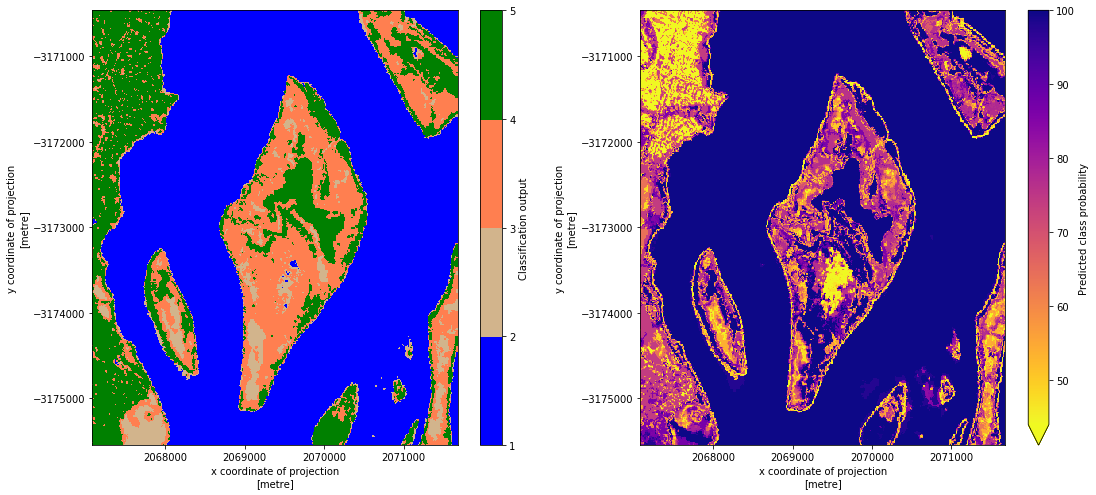

In [6]:
# Plot output classification
class_xarray = xr.DataArray(class_array,
                            coords=[analysis_xarray.y, analysis_xarray.x],
                            dims=['y', 'x'],
                            name='Classification output')

prob_xarray = xr.DataArray(prob_array,
                           coords=[analysis_xarray.y, analysis_xarray.x],
                           dims=['y', 'x'],
                           name='Predicted class probability')

fig, axes = plt.subplots(ncols=2, figsize=(18, 8))
class_xarray.plot(ax=axes[0], levels=list(np.unique(class_array))+[len(np.unique(class_array))+1],cmap=['blue', 'tan', 'coral', 'green'])
prob_xarray.plot(ax=axes[1], cmap='plasma_r',
                 vmin=np.percentile(prob_array, 3),
                 vmax=np.percentile(prob_array, 97))

for name, integer in zip(classification_names, np.unique(class_array)):
    print("Class " +str(int(integer))+" = " + name)

## Evaluating Classifier

The following cells will help you examine the classifier and improve the results.  We can do this by:
- finding out which features (bands in the input data) are most useful for classifying, and which are not
- by testing different input parameters to help us optimise the model
- and by exporting the tree diagrams for each decision tree to help us understand how the RF classifier has made its decisions. 

### Determine Feature Importance

Extract classifier estimates of the relative importance of each band/variable for training the classifier. Useful for potentially selecting a subset of input bands/variables for model training/classification (i.e. optimising feature space). Results will be presented in descending order with the most important features listed first.  Importance is reported as a relative fraction between 0 and 1.

In [7]:
#print the OOB accuracy
print('The "Out-of-Bag" prediction of accuracy is: {oob}%'.format(oob=classifier.oob_score_ * 100))

#display the relative importance of each feature
importance = classifier.feature_importances_
importance_df = pd.DataFrame({
    'variable': analysis_xarray.data_vars,
    'importance': importance})

importance_df.set_index("variable", inplace=True)
display(importance_df.sort_values('importance',ascending=False))


The "Out-of-Bag" prediction of accuracy is: 100.0%


,importance
variable,
nbart_red_edge_3,0.156213
msavi_mean,0.121366
nbart_red_edge_2,0.121301
nbart_swir_2,0.094890
inundation_freq,0.092725
nbart_nir_1,0.085688
mndwi_mean,0.085619
nbart_nir_2,0.061452
msavi_max,0.053138


### Test parameter values of RF model

This will help us determine which paramater values are best to use for our model. The function `GridSearchCV` will exhaustively search through the parameters in `param_grid` and determine which combination will result in the highest accuracy (based on the out-of-bag metric).  You can enter more parameters into the `param_grid` object, but be aware that the number of iterations to check will become exponentially larger as you enter more parameters. It's better practice to check only those parameters you think are likely to make a big difference to the model's accuracy. The code below will take a few minutes to run.

In [8]:
param_grid = {
    "max_features": ['sqrt', 'log2', 'auto'],
    "n_estimators" : [100,200,500],
    'criterion': ['entropy', 'gini'],
    'max_depth': [1,2,5]
}

grid_search = GridSearchCV(classifier, param_grid, cv=3)
grid_search.fit(train_samp, train_lab)

print("The most accurate combination of tested parameters is: ")
pprint(grid_search.best_params_)

The most accurate combination of tested parameters is: 
{'criterion': 'entropy',
 'max_depth': 5,
 'max_features': 'sqrt',
 'n_estimators': 100}


### Export tree diagrams

Export .png plots of each decision tree in the random forest ensemble. Useful for inspecting the splits used by the classifier to classify the data.

In [9]:
for n, tree_in_forest in enumerate(classifier.estimators_):    

    # Create graph and save to dot file
    export_graphviz(tree_in_forest,
                    out_file = tree_graphs + "tree.dot",
                    feature_names = list(analysis_xarray.data_vars),
                    class_names = classification_names,
                    filled = True,
                    rounded = True)

    # Plot as figure
    os.system('dot -Tpng ' + tree_graphs + 'tree.dot -o ' + tree_graphs + 'tree' + str(n + 1) + '.png')    

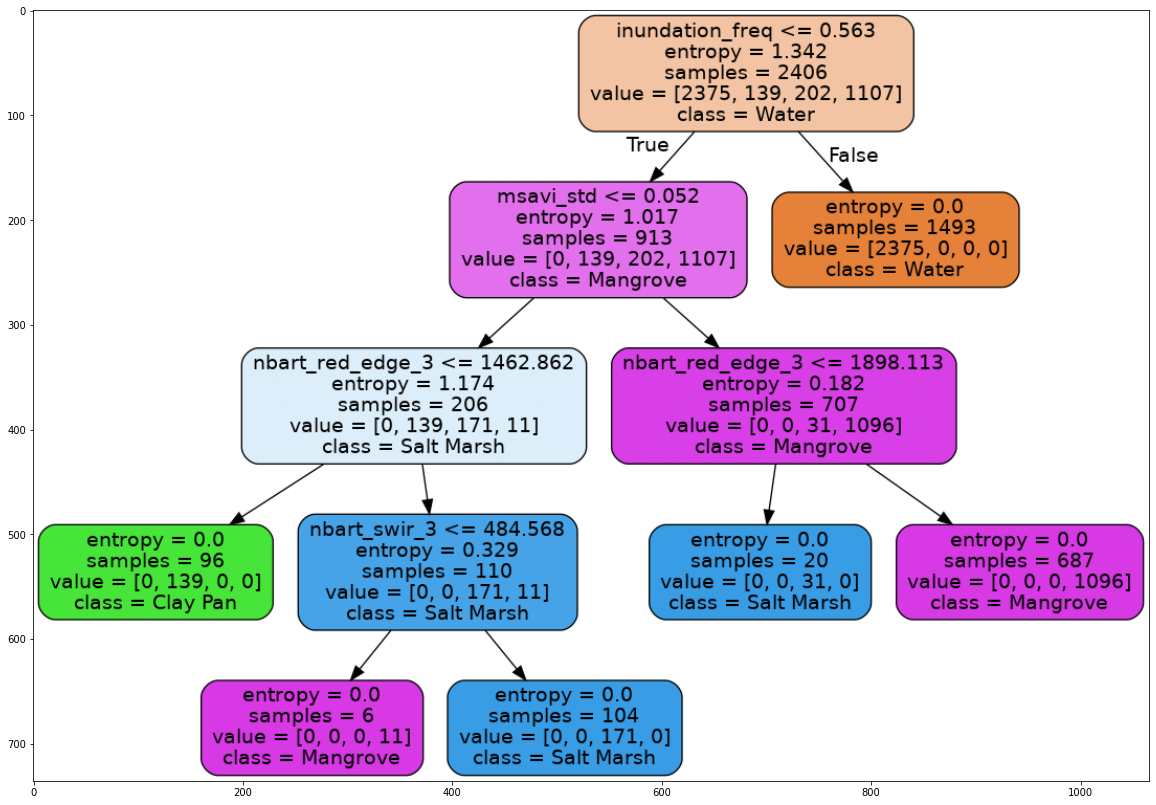

In [10]:
# Plot any tree
tree_number = 'tree5'

img = plt.imread(tree_graphs + tree_number + '.png')
plt.figure(figsize = (20, 20))
plt.imshow(img, interpolation = "bilinear")